# Report on worksheet data and log data
This notebook reports different statistics and visuals on worksheet data and how it relates to log data

In [1]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

In [68]:
%load_ext autoreload
%autoreload 1
%aimport utils_read_parsing
from utils_timeline_viz import *
from utils_read_parsing import *
import matplotlib.pyplot as plt
from tabulate import tabulate
from scipy.stats import mannwhitneyu
import seaborn as sns
%matplotlib inline
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = 7, 4
pd.set_option('precision',3)
np.set_printoptions(precision=3,suppress=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Preparing the data
First we load the data generated by the cvs_skills_detector.ipynb
and the worksheet data

Here is what the data looks like:

In [69]:
table_cvs_df = pd.read_csv('table_cvs_results.txt', sep='\t')
graph_cvs_df = pd.read_csv('graph_cvs_results.txt', sep='\t')

In [70]:
metadf = get_student_metadata()
order = dict(zip(metadf.index,metadf['activity order']))
graph_cvs_df['activity order'] = graph_cvs_df.studentid.apply(lambda sid: order[sid])
table_cvs_df['activity order'] = table_cvs_df.studentid.apply(lambda sid: order[sid])

In [71]:
graph_cvs_df = graph_cvs_df.replace(to_replace=2,value=0)
table_cvs_df = table_cvs_df.replace(to_replace=2,value=0)
table_cvs_df.head()

,studentid,Battery voltage,Area,Separation,Wavelength,Width,Concentration,activity order
0,11612162,0,0,0,3,0,3,CL
1,13660166,0,0,0,0,0,14,LC
2,41947147,0,0,0,14,6,7,CL
3,64006159,0,0,0,5,0,6,LC
4,15749160,0,0,3,0,4,10,CL


In [72]:
variables = ["Battery voltage","Area","Separation","Wavelength","Width","Concentration"]

def binarize(number):
    if number>0 : return 1
    else: return 0

graph_cvs_df2 = graph_cvs_df.copy()
for v in variables:
    graph_cvs_df2[v] = graph_cvs_df.apply(lambda row: binarize(row[v]), axis=1)

table_cvs_df2 = table_cvs_df.copy()
for v in variables:
    table_cvs_df2[v] = table_cvs_df.apply(lambda row: binarize(row[v]), axis=1)

graph_cvs_df2['sum'] = graph_cvs_df2[variables].sum(axis=1)
table_cvs_df2['sum'] = table_cvs_df2[variables].sum(axis=1)
table_cvs_df2['sum caps'] = table_cvs_df2[['Battery voltage','Area','Separation']].sum(axis=1)
table_cvs_df2['sum light absorbance'] = table_cvs_df2[["Wavelength","Width","Concentration"]].sum(axis=1)
graph_cvs_df2['sum caps'] = graph_cvs_df2[['Battery voltage','Area','Separation']].sum(axis=1)
graph_cvs_df2['sum light absorbance'] = graph_cvs_df2[["Wavelength","Width","Concentration"]].sum(axis=1)

In [142]:
%reload_ext utils_read_parsing
pre = get_pre_worksheet(sim='beers')
pre= pre[pre['Student ID'].isin(worksheets[(worksheets['Type']=='p')&worksheets['Student ID'].isin(ids)]['other id'].values)]
main = get_main_worksheet(sim='beers')
main= main[main['Student ID'].isin(worksheets[(worksheets['Type']=='m')&worksheets['Student ID'].isin(ids)]['other id'].values)]
print len(ids),len(pre),len(main)

135 135 135


In [154]:
pre['id in logs'] = pre['Student ID'].apply(lambda row: worksheets.loc[worksheets[worksheets['other id']==row].index[0],'Student ID'])
main['id in logs'] = main['Student ID'].apply(lambda row: worksheets.loc[worksheets[worksheets['other id']==row].index[0],'Student ID'])

# Overall, do students learn?
Before we dig into the use of CVS, let's look at how much students learn from pre to post

## Descriptives stats on learning

In [155]:
pre['mean'] = pre[['Concentration','Wavelength','Width']].mean(axis=1)
main['mean'] = main[['Concentration','Wavelength','Width']].mean(axis=1)
pre.head()

,Student ID,Concentration,Wavelength,Width,id in logs,mean
0,10127163,1.0,1.0,1.0,10127163,1.000
1,10232160,1.0,1.0,1.0,10232160,1.000
2,10375160,1.0,1.0,0.0,10537160,0.667
3,10375163,0.0,1.0,1.0,10375163,0.667
4,10420167,1.0,1.0,0.0,10420167,0.667


''

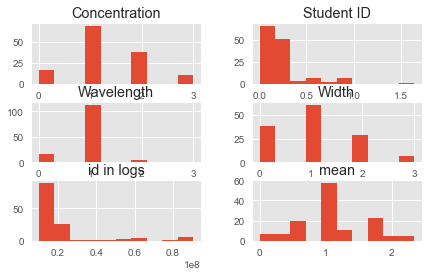

In [156]:
pre.hist()
''

''

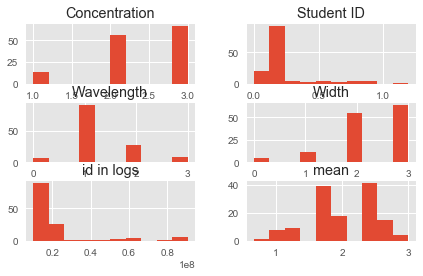

In [157]:
main.hist()
''

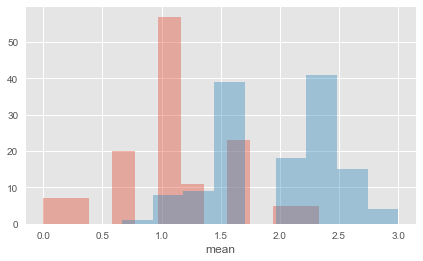

In [187]:
sns.distplot(pre['mean'],kde=False)
sns.distplot(main['mean'],kde=False)

Heatmap of pre by post grades


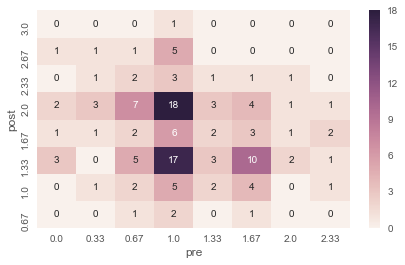

In [159]:
n_bins = max(len(set(pre['mean'].values)),len(set(main['mean'].values)))
heatmap, xedges, yedges = np.histogram2d(pre['mean'], main['mean'], bins=n_bins)
ax= sns.heatmap(heatmap.T,annot=True)
ax.set(xlabel='pre', ylabel='post',xticklabels = sorted([round(x,2) for x in set(pre['mean'])]),yticklabels = sorted([round(x,2) for x in set(main['mean'])]))
print 'Heatmap of pre by post grades'

Overall, yes students learn. Mostly their scores improve for the quantitative variables.

## Quick comparison test of scores per variable

In [185]:
# print "Mean sample size for each variable, excluding sample sizes of zero by activity order."
p = [['','pre','main',"Mann Whitney U",'p-value']]
for v in ['Concentration','Width','Wavelength','mean']:
    pm = np.mean(pre[v].values)
    ps = np.std(pre[v].values)
    mm = np.mean(main[v].values)
    ms = np.std(main[v].values)
    mann,pv = mannwhitneyu(pre[v].values,main[v].values)
    p.append([v,str(round(pm,2))+' +- '+str(round(ps,2)),str(round(m,2))+' +- '+str(round(ms,2)),mann,pv])
print tabulate(p)

-------------  ------------  ------------  --------------  -----------------
               pre           main          Mann Whitney U  p-value
Concentration  1.32 +- 0.79  2.39 +- 0.66  3128.5          5.81907726184e-23
Width          1.04 +- 0.84  2.39 +- 0.78  2718.0          2.27512117145e-25
Wavelength     0.92 +- 0.42  2.39 +- 0.65  6631.5          1.18835227783e-07
mean           1.09 +- 0.52  2.39 +- 0.5   2113.5          6.88654315966e-29
-------------  ------------  ------------  --------------  -----------------


## Finally, a stats model
First we put everything in one dataframe

In [165]:
scores = pre[['id in logs']]
scores['pre '] = scores['id in logs'].apply(lambda row: pre.loc[pre[pre['id in logs']==row].index[0],'mean'])
scores['main'] = scores['id in logs'].apply(lambda row: main.loc[main[main['id in logs']==row].index[0],'mean'])
order = dict(zip(metadf.index,metadf['activity order']))
scores['order'] = scores['id in logs'].apply(lambda sid: order[sid])

d:\applications\anaconda2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
d:\applications\anaconda2\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
d:\applications\anaconda2\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

In [166]:
scores.head()

,id in logs,pre,main,order
0,10127163,1.000,2.333,LC
1,10232160,1.000,1.000,LC
2,10537160,0.667,1.000,CL
3,10375163,0.667,1.333,CL
4,10420167,0.667,2.667,CL


In [170]:
import statsmodels.api as sm
pd.set_option("display.width", 100)
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from statsmodels.graphics.api import interaction_plot, abline_plot
from statsmodels.stats.anova import anova_lm

In [178]:
def eta_squared(aov):
    aov['eta_sq'] = 'NaN'
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    return aov
 
def omega_squared(aov):
    mse = aov['sum_sq'][-1]/aov['df'][-1]
    aov['omega_sq'] = 'NaN'
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*mse))/(sum(aov['sum_sq'])+mse)
    return aov

In [181]:
formula = 'main ~ pre + C(order) + pre*C(order)'
model = ols(formula, scores).fit()
print model.summary()

                            OLS Regression Results                            
Dep. Variable:                   main   R-squared:                       0.140
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     1.825
Date:                Thu, 14 Dec 2017   Prob (F-statistic):             0.0565
Time:                        17:56:57   Log-Likelihood:                -86.931
No. Observations:                 135   AIC:                             197.9
Df Residuals:                     123   BIC:                             232.7
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 2.10

In [182]:
aov_table = anova_lm(model, typ=2)
eta_squared(aov_table)
omega_squared(aov_table)
print(aov_table)

              sum_sq     df      F  PR(>F)  eta_sq  omega_sq
C(order)       1.316    1.0  5.649   0.019   0.039     0.032
pre            2.343    6.0  1.676   0.132   0.070     0.028
pre:C(order)   1.051    6.0  0.752   0.609   0.032    -0.010
Residual      28.653  123.0    NaN     NaN     NaN       NaN


So a high pre doesn't predict a high main score?? Interesting...
Perhaps because the main score really tests their inquiry skills. Possibly prior knowledge neither helped nor hindered the producitivity of the student, only inquiry skills matter???

# Score and use of CVS